# Baseline_KJY

## Loading Data

In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
import numpy as np
from datetime import datetime
import time

import pylab as plot

# 행 많이보기
pd.set_option('display.max_row',100)
pd.set_option('display.max_columns', 100)

# 한글 폰트 설정
fm.get_fontconfig_fonts()
font_location = 'C:/Windows/Fonts/NanumGothic.ttf' # For Windows
font_name = fm.FontProperties(fname=font_location).get_name()
plt.rc('font', family=font_name)
plt.rc('font', size=12)
plt.figure(figsize=(20,10))

# 지수 표현 안보기

# 데이터 로드
data = pd.read_excel('./Data/2019_data_time.xlsx', encoding='cp949', header=0, parse_dates=["방송일시"])

# 무형 제거

data.drop(data[data['상품군']=='무형'].index, inplace=True)
data.reset_index(inplace=True)



# 판매단가, 취급액 쉼표 제거 , int 변환

# data['판매단가'] = data['판매단가'].str.replace(',','').astype(int)
# data['취급액'] = data['취급액'].str.replace(',','').astype(int)
# data['노출(분)'] = data['노출(분)'].astype(int)



# 취급액 결측치 값 변경
# df.loc[df['취급액']==1]['취급액'] = 50000



# 날짜 변경 ( 다음날 데이터를 현재 날짜로 할 건지 )




# data 의 colname 영어로 변경
# index drop 필요
print(data.columns)
data.columns = ['index', 'time', 'exposure_time', 'mcode', 'product_code', 'product_name', 'category','price','salesAMT']
print(data.columns)
                
# M', 'D', 'day', 'H', 'm',
#3

Index(['index', '방송일시', '노출(분)', '마더코드', '상품코드', '상품명', '상품군', '판매단가', '취급액'], dtype='object')
Index(['index', 'time', 'exposure_time', 'mcode', 'product_code',
       'product_name', 'category', 'price', 'salesAMT'],
      dtype='object')


<Figure size 1440x720 with 0 Axes>

# 전처리

## time feature

In [2]:
data['time_month']    = data['time'].dt.month        # 월(숫자)
data['time_day']        = data['time'].dt.day          # 일(숫자)
data['time_hour']       = data['time'].dt.hour         # 시(숫자)
data['time_minute']     = data['time'].dt.minute       # 분(숫자)
data['weekofyear']    = data['time'].dt.weekofyear      # 연 기준 몇주째(숫자) (=week)
data['dayofyear']     = data['time'].dt.dayofyear       # 연 기준 몇일째(숫자)
data["day_of_the_week"] = data["time"].dt.dayofweek
data['date']        = data['time'].dt.date          # 년월일

In [3]:
# 홈쇼핑 하루 방송 사이클이 오전 06시(06시20분)~익일 02시(02시20분) 까지 이므로 날짜를 맞춰주는 작업 수행
# 0시~3시 사이의 방송시간을 24시~27시로 변경
# 방송 날짜와 요일을 하루전으로 변경
overnight_index_list = data.loc[(data["time_hour"] >=0) & (data["time_hour"] < 3)].index
overnight_index_list
data.loc[overnight_index_list, "time_hour"] += 24
data.loc[overnight_index_list, "time_day"] -= 1
data.loc[overnight_index_list, "dayofyear"] -= 1
data.loc[overnight_index_list, "day_of_the_week"] -= 1
data.loc[data["day_of_the_week"] == -1, "day_of_the_week"] = 6

In [4]:
# 다음달로 넘어가거나 다음연도로 넘어간 항목은 월,일 재조정
data.loc[(data["time_month"] == 2) & (data["time_day"] == 0), ["time_month", "time_day"]] = 1, 31
data.loc[(data["time_month"] == 3) & (data["time_day"] == 0), ["time_month", "time_day"]] = 2, 28
data.loc[(data["time_month"] == 4) & (data["time_day"] == 0), ["time_month", "time_day"]] = 3, 31
data.loc[(data["time_month"] == 5) & (data["time_day"] == 0), ["time_month", "time_day"]] = 4, 30
data.loc[(data["time_month"] == 6) & (data["time_day"] == 0), ["time_month", "time_day"]] = 5, 31
data.loc[(data["time_month"] == 7) & (data["time_day"] == 0), ["time_month", "time_day"]] = 6, 30
data.loc[(data["time_month"] == 8) & (data["time_day"] == 0), ["time_month", "time_day"]] = 7, 31
data.loc[(data["time_month"] == 9) & (data["time_day"] == 0), ["time_month", "time_day"]] = 8, 31
data.loc[(data["time_month"] == 10) & (data["time_day"] == 0), ["time_month", "time_day"]] = 9, 30
data.loc[(data["time_month"] == 11) & (data["time_day"] == 0), ["time_month", "time_day"]] = 10, 31
data.loc[(data["time_month"] == 12) & (data["time_day"] == 0), ["time_month", "time_day"]] = 11, 30
data.loc[(data["time_month"] == 1) & (data["time_day"] == 0), ["time_month", "time_day"]] = 12, 31

In [5]:
data[-4:]['dayofyear'] = 365

C:\Users\cjswo\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## 기상 feature 추가 (지역별 인구수에 가중치 부여)

### 데이터 불러오기

In [6]:
# 지역별 데이터 불러오기
seoul_df = pd.read_csv('./Data/서울.csv', encoding = 'euc-kr')
busan_df = pd.read_csv('./Data/부산.csv', encoding = 'euc-kr')
inchon_df = pd.read_csv('./Data/인천.csv', encoding = 'euc-kr')
daeseon_df = pd.read_csv('./Data/대전.csv', encoding = 'euc-kr')
daegu_df = pd.read_csv('./Data/대구.csv', encoding = 'euc-kr')
ulsan_df = pd.read_csv('./Data/울산.csv', encoding = 'euc-kr')
gwangzu_df = pd.read_csv('./Data/광주.csv', encoding = 'euc-kr')

# 지역별 인구수
seoul = 9729107
busan = 3413841
inchon = 2957026
daeseon = 1474870
daegu = 2438031
ulsan = 1148019
gwangzu = 1456468

# 지역별 인구수 합
total = seoul+busan+inchon+daeseon+ulsan+seoul+gwangzu

# 지역별 인구수 비율
seoul_rate = seoul/total
busan_rate = busan/total
inchon_rate = inchon/total
daeseon_rate = daeseon/total
daegu_rate = daegu/total
ulsan_rate = ulsan/total
gwangzu_rate = gwangzu/total

# 결측값 처리
seoul_df.fillna(0, inplace = True)
busan_df.fillna(0, inplace = True)
inchon_df.fillna(0, inplace = True)
daeseon_df.fillna(0, inplace = True)
daegu_df.fillna(0, inplace = True)
ulsan_df.fillna(0, inplace = True)
gwangzu_df.fillna(0, inplace = True)

# 비율 반영

seoul_df2 = seoul_df.drop(['일시','지점','지점명'],axis = 1)*seoul_rate
busan_df2 = busan_df.drop(['일시','지점','지점명'],axis = 1)*busan_rate 
inchon_df2 = inchon_df.drop(['일시','지점','지점명'],axis = 1)*inchon_rate
daeseon_df2 = daeseon_df.drop(['일시','지점','지점명'],axis = 1)*daeseon_rate
daegu_df2 = daegu_df.drop(['일시','지점','지점명'],axis = 1)*daegu_rate
ulsan_df2 = ulsan_df.drop(['일시','지점','지점명'],axis = 1)*ulsan_rate
gwangzu_df2 = gwangzu_df.drop(['일시','지점','지점명'],axis = 1)*gwangzu_rate

# 데이터 프레임 병합

#r_df = seoul_df2 + busan_df2 + inchon_df2 + daeseon_df2 + daegu_df2 + ulsan_df2 + gwangzu_df2 
r_df = seoul_df.drop(['일시','지점','지점명'],axis = 1)
r_df['date'] = seoul_df['일시']
r_df['date'] = pd.to_datetime(r_df['date'], format='%Y-%m-%d %H:%M:%S', errors='raise')
r_df['dayofyear'] = r_df['date'].dt.dayofyear
r_df.drop(['일 최심신적설(cm)','최대 순간 풍속(m/s)'],axis = 1 ,inplace = True)
r_df.drop(365, inplace = True)
r_df

,평균기온(°C),최저기온(°C),최고기온(°C),강수 계속시간(hr),1시간 최다강수량(mm),일강수량(mm),최대 풍속(m/s),평균 풍속(m/s),최소 상대습도(%),평균 상대습도(%),date,dayofyear
0,-5.0,-8.2,-0.6,0.00,0.0,0.0,4.3,2.1,34,49.5,2019-01-01,1
1,-4.9,-8.8,0.2,0.00,0.0,0.0,3.6,1.7,20,42.8,2019-01-02,2
2,-3.5,-8.4,3.2,0.00,0.0,0.0,2.9,1.4,18,38.8,2019-01-03,3
3,-1.1,-6.2,4.1,0.00,0.0,0.0,3.0,1.2,34,55.5,2019-01-04,4
4,-2.8,-5.5,1.1,0.00,0.0,0.0,4.3,2.2,20,40.3,2019-01-05,5
...,...,...,...,...,...,...,...,...,...,...,...,...
360,-1.7,-4.6,2.6,0.00,0.0,0.0,4.3,2.1,23,45.4,2019-12-27,361
361,1.1,-3.6,6.1,0.00,0.0,0.0,3.7,2.0,34,47.6,2019-12-28,362
362,3.8,1.1,6.2,6.75,0.0,1.4,4.4,2.9,37,52.5,2019-12-29,363
363,2.7,-5.7,6.8,5.08,0.0,0.4,7.4,2.9,43,70.3,2019-12-30,364


### Reindexing

In [7]:
r_df.columns = ['mean_temp','min_temp','max_temp','raining_dur(hr)','rain_per_hour','rain_per_day','max_wind',
             'mean_wind','min_Humidity','mean_Humidity','date','dayofyear']

### DataFrame 병합

In [8]:
data = pd.merge(data,r_df,on = 'dayofyear', how='left')

In [9]:
data

,index,time,exposure_time,mcode,product_code,product_name,category,price,salesAMT,time_month,time_day,time_hour,time_minute,weekofyear,dayofyear,day_of_the_week,date_x,mean_temp,min_temp,max_temp,raining_dur(hr),rain_per_hour,rain_per_day,max_wind,mean_wind,min_Humidity,mean_Humidity,date_y
0,0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0,1,1,6,0,1,1,1,2019-01-01,-5.0,-8.2,-0.6,0.00,0.0,0.0,4.3,2.1,34,49.5,2019-01-01
1,1,2019-01-01 06:00:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0,1,1,6,0,1,1,1,2019-01-01,-5.0,-8.2,-0.6,0.00,0.0,0.0,4.3,2.1,34,49.5,2019-01-01
2,2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0,1,1,6,20,1,1,1,2019-01-01,-5.0,-8.2,-0.6,0.00,0.0,0.0,4.3,2.1,34,49.5,2019-01-01
3,3,2019-01-01 06:20:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0,1,1,6,20,1,1,1,2019-01-01,-5.0,-8.2,-0.6,0.00,0.0,0.0,4.3,2.1,34,49.5,2019-01-01
4,4,2019-01-01 06:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0,1,1,6,40,1,1,1,2019-01-01,-5.0,-8.2,-0.6,0.00,0.0,0.0,4.3,2.1,34,49.5,2019-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37367,38299,2019-12-31 23:40:00,20.0,100448,201391,일시불쿠첸압력밥솥 6인용,주방,148000,10157000.0,12,31,23,40,1,365,1,2019-12-31,-7.9,-10.9,-4.5,1.58,0.0,0.0,7.5,3.1,26,39.3,2019-12-31
37368,38300,2020-01-01 00:00:00,20.0,100448,201383,무이자쿠첸압력밥솥 10인용,주방,178000,50929000.0,12,31,24,0,1,365,1,2020-01-01,-7.9,-10.9,-4.5,1.58,0.0,0.0,7.5,3.1,26,39.3,2019-12-31
37369,38301,2020-01-01 00:00:00,20.0,100448,201390,일시불쿠첸압력밥솥 10인용,주방,168000,104392000.0,12,31,24,0,1,365,1,2020-01-01,-7.9,-10.9,-4.5,1.58,0.0,0.0,7.5,3.1,26,39.3,2019-12-31
37370,38302,2020-01-01 00:00:00,20.0,100448,201384,무이자쿠첸압력밥솥 6인용,주방,158000,13765000.0,12,31,24,0,1,365,1,2020-01-01,-7.9,-10.9,-4.5,1.58,0.0,0.0,7.5,3.1,26,39.3,2019-12-31


## 상품군 category 별 분류

In [10]:
# 카테고리명 영어로 변경
data.loc[data["category"] == "의류", "category"] = "clothes"
data.loc[data["category"] == "속옷", "category"] = "underwear"
data.loc[data["category"] == "주방", "category"] = "kitchen"
data.loc[data["category"] == "농수축", "category"] = "food"
data.loc[data["category"] == "이미용", "category"] = "beauty"
data.loc[data["category"] == "가전", "category"] = "electronics"
data.loc[data["category"] == "생활용품", "category"] = "necessaries"
data.loc[data["category"] == "건강기능", "category"] = "health"
data.loc[data["category"] == "잡화", "category"] = "goods"
data.loc[data["category"] == "가구", "category"] = "furniture"
data.loc[data["category"] == "침구", "category"] = "bedding"


In [11]:
# 상품군 one-hot encoding
data_dummy = pd.get_dummies(data, columns=['category'], prefix='category', drop_first=True)


data_dummy = pd.get_dummies(data_dummy, columns=['time_hour'], prefix='time_hour', drop_first=True)


data_dummy = pd.get_dummies(data_dummy, columns=['time_month'], prefix='time_month', drop_first=True)


data_dummy = pd.get_dummies(data_dummy, columns=['day_of_the_week'], prefix='day_of_the_week', drop_first=True)

data_dummy.drop(columns=['index','time','product_code'],inplace=True)

## 온도 변수 스케일링

In [252]:
data_dummy['max_temp_scaled'] = np.absolute(data_dummy['max_temp']-data_dummy['max_temp'].mean())



## Feature Correalation 확인

In [227]:
import seaborn as sns
from matplotlib import pyplot as plt
#plt.figure(figsize=(25,25))
#sns.heatmap(data_dummy.corr(), annot=True, cmap='PuBu')
#plt.show()

* 상관관계 높은 유사 변수 제거 필요

# ML model

## Define MAPE

In [13]:
def MAPE(y_true, y_pred): 

    return np.mean(np.abs((y_pred-y_true) / y_true)) * 100

## RF

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score

### Validation Data

In [15]:
# 이상치 제거
data_dummy = data_dummy.drop(data_dummy[data_dummy['salesAMT'] == 50000].index)

In [16]:
data = data.drop(data[data['salesAMT'] == 50000].index)

In [17]:
data_dummy.columns

Index(['exposure_time', 'mcode', 'product_name', 'price', 'salesAMT',
       'time_day', 'time_minute', 'weekofyear', 'dayofyear', 'date_x',
       'mean_temp', 'min_temp', 'max_temp', 'raining_dur(hr)', 'rain_per_hour',
       'rain_per_day', 'max_wind', 'mean_wind', 'min_Humidity',
       'mean_Humidity', 'date_y', 'category_bedding', 'category_clothes',
       'category_electronics', 'category_food', 'category_furniture',
       'category_goods', 'category_health', 'category_kitchen',
       'category_necessaries', 'category_underwear', 'time_hour_7',
       'time_hour_8', 'time_hour_9', 'time_hour_10', 'time_hour_11',
       'time_hour_12', 'time_hour_13', 'time_hour_14', 'time_hour_15',
       'time_hour_16', 'time_hour_17', 'time_hour_18', 'time_hour_19',
       'time_hour_20', 'time_hour_21', 'time_hour_22', 'time_hour_23',
       'time_hour_24', 'time_hour_25', 'time_hour_26', 'time_month_2',
       'time_month_3', 'time_month_4', 'time_month_5', 'time_month_6',
       'time_mo

In [280]:
X = data_dummy.drop(['salesAMT','product_name', 'date_x',
        'date_y','min_temp','max_temp','mean_temp','mean_wind'], axis = 1)

y = data_dummy['salesAMT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 777)

### Model

In [ ]:
rfc = RandomForestRegressor(random_state = 777)


param ={
    'n_estimators'      : [100],
    'max_depth'         : [20],
    'min_samples_leaf'  : [4],
    'min_samples_split' : [2],
    'bootstrap' : [True]
}

grid_rfc = GridSearchCV(rfc, param_grid = param)

grid_rfc.fit(X_train, y_train)

print('최적 파라미터      : ', grid_rfc.best_params_)
print('최고 예측 정확도   : {0:.4f}'.format(grid_rfc.best_score_))

estimator = grid_rfc.best_estimator_

pred = estimator.predict(X_test)
print('검증 데이터 정확도 : {0:.4f}'.format(r2_score(y_test, pred)))

### MAPE

In [ ]:
MAPE(y_test, pred)

### Feature importance

In [ ]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

#피처 중요도 도표 그리기
featureImportance = estimator.feature_importances_
#가장 높은 중요도 기준으로 스케일링
featureImportance = featureImportance/featureImportance.max()
sorted_idx = np.argsort(featureImportance[:])
barPos = np.arange(sorted_idx[:].shape[0])+ .5
plot.barh(barPos, featureImportance[sorted_idx[:]], align='center')
plot.yticks(barPos, X_train.keys()[sorted_idx][:])
plot.xlabel('Variable Importance')
plot.show()

In [ ]:
X_train.keys()[sorted_idx][:]

## LGBM

### Model

In [286]:
import lightgbm as lgb

model = lgb.LGBMRegressor(random_state=777, n_estimators=1000,max_depth = -1,learning_rate = 0.01,lambda_l1 = 0.001, 
                          lambda_l2 = 0.001,num_iterations = 30000)
model.fit(X_train, y_train)
predicted = model.predict(X_test)
model_score = MAPE(y_test, predicted)

C:\Users\cjswo\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


### MAPE score

In [287]:
model_score

49.85255180941991

* 기상데이터 추가시 58.93 ->60.29
* 유사한 상품명 취급액 추가시 59.33 -> 49.96

### Feature importance

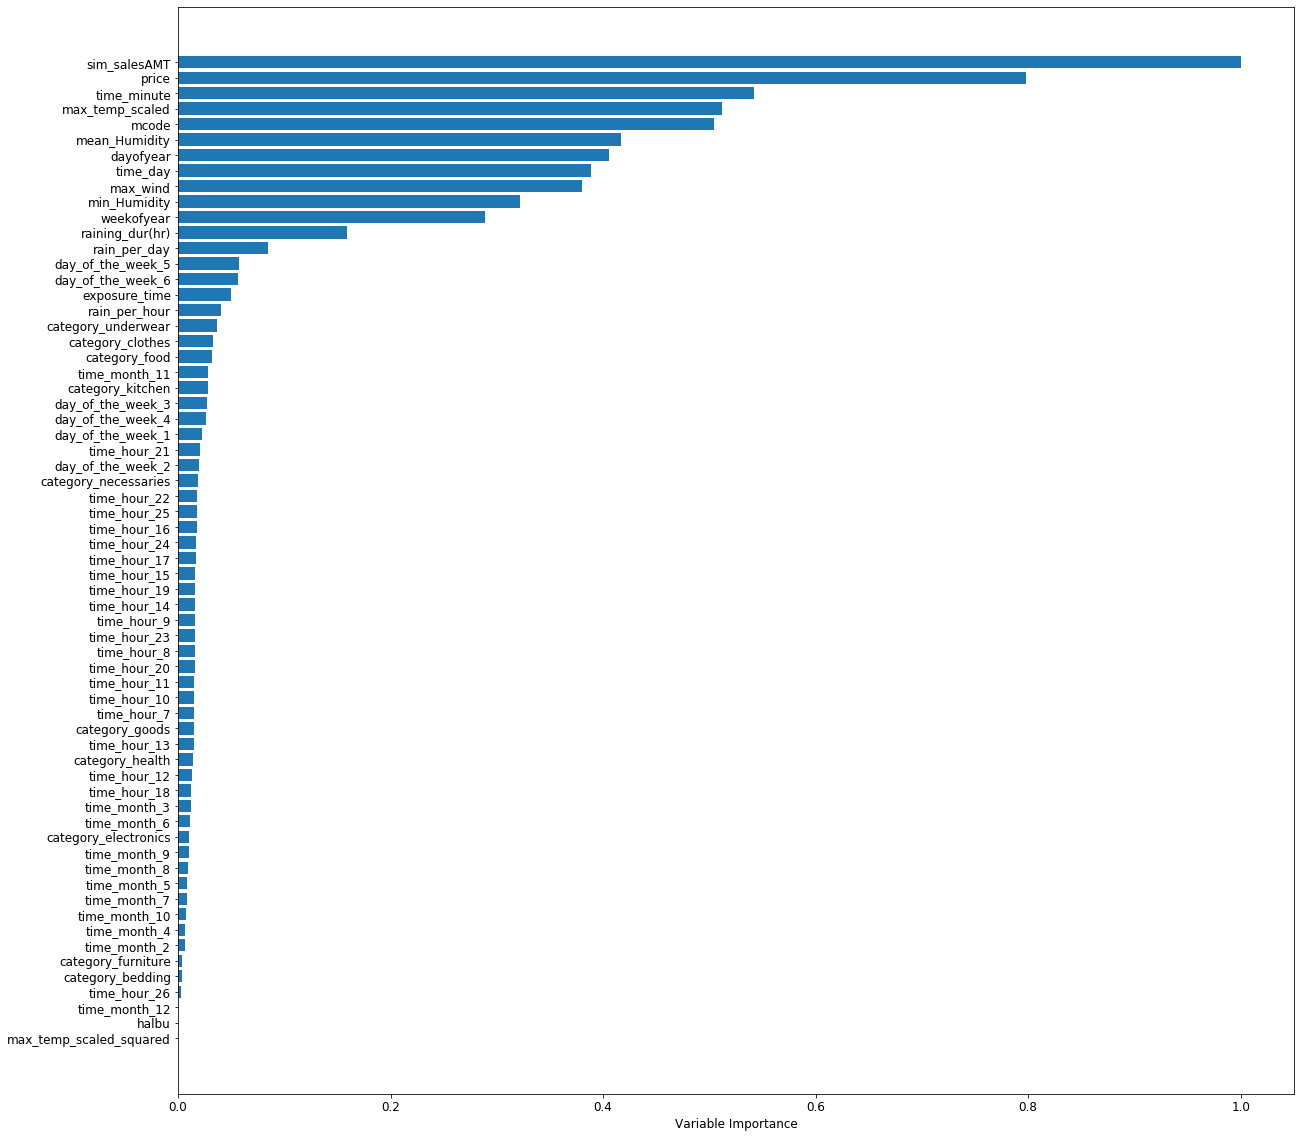

In [283]:
featureImportance = model.feature_importances_
#가장 높은 중요도 기준으로 스케일링
featureImportance = featureImportance/featureImportance.max()
sorted_idx = np.argsort(featureImportance[:])
barPos = np.arange(sorted_idx[:].shape[0])+ .5
plt.figure(figsize=(20,20))
plot.barh(barPos, featureImportance[sorted_idx[:]], align='center')
plot.yticks(barPos, X_train.keys()[sorted_idx][:])
plot.xlabel('Variable Importance')
plot.show()

# 자연어 처리

## 단어 빈도수 조사

In [217]:
import os
import pickle
from sklearn.feature_extraction.text import CountVectorizer


In [218]:
sentences = list(data['product_name'])

In [219]:
def create_BOW(sentence,bow):
    words = sentence.split(" ")
    words = [i for i in words if i != ""]
    for word in words:
        if word == "":
            pass
        try : bow[word] += 1
        except : bow[word] = 1
    
    return bow

In [220]:
bow = {}
for s in sentences:
    create_BOW(s,bow)

In [221]:
bow_sorted = sorted(bow.items(), key=lambda x: x[1], reverse=True)
bow_sorted[:20]

[('일시불', 4937),
 ('무이자', 4930),
 ('엘지', 2837),
 ('티비', 2231),
 ('울트라', 1838),
 ('에이치디', 1838),
 ('남성', 1603),
 ('쿠쿠전기밥솥', 1495),
 ('여성', 1347),
 ('3종', 1196),
 ('쿠첸', 1174),
 ('압력밥솥', 1168),
 ('패키지', 1155),
 ('침대', 1130),
 ('LED', 1102),
 ('6인용', 1064),
 ('삼성', 1030),
 ('푸마', 1010),
 ('보루네오', 786),
 ('유로탑', 783)]

In [222]:
bow_df = pd.DataFrame(bow.values(), index = bow.keys())
bow_df.sort_values(0,axis = 0, inplace = True, ascending = False)

bow_df['word freq'] = bow_df[0]

bow_df.drop(0, axis = 1, inplace = True)

bow_df['freq rate(%)'] = bow_df['word freq']*100/len(data)
print(bow_df['word freq'].sum())
bow_df.head(20)

158995


,word freq,freq rate(%)
일시불,4937,13.954606
무이자,4930,13.934820
엘지,2837,8.018881
티비,2231,6.306001
에이치디,1838,5.195172
울트라,1838,5.195172
남성,1603,4.530936
쿠쿠전기밥솥,1495,4.225671
여성,1347,3.807343
3종,1196,3.380536


* 무이자 일시불 비율 약 30% -> feature로 사용가능성 o

## 무이자 일시불 취급액 차이 비교

In [214]:
index_m2 = []
for i in range(len(data)):
    if data['product_name'].iloc[i].split(" ")[0] == '무이자':
        index_m2.append(i)
        
index_1 = []
for i in range(len(data)):
    if data['product_name'].iloc[i].split(" ")[0] == '일시불':
        index_1.append(i)

In [29]:
df_m2 = data.iloc[index_m2]
df_1 = data.iloc[index_1]

In [30]:
print('무이자 평균 취급액 : ',df_m2['salesAMT'].mean())
print('일시불 평균 취급액 : ',df_1['salesAMT'].mean())
print('전체 평균 취급액 : ',data['salesAMT'].mean())

무이자 평균 취급액 :  15337868.909276249
일시불 평균 취급액 :  17515800.651598454
전체 평균 취급액 :  23102409.22581192


In [31]:
df_1['salesAMT'].mean()/df_m2['salesAMT'].mean()

1.1419970241762207

* 일시불 상품이 무이자 상품보다 약 15% 정도 평균 취급액 높음

In [215]:
data_dummy['halbu'] = 0
data_dummy['halbu'][index_m2] = 1

data_dummy['pay_1'] = 0
data_dummy['pay_1'][index_1] = 1

C:\Users\cjswo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


ValueError: [  147   153   154  1692  1737  1741  1941  2243  2321  2494  2498  2717
  3035  3098  3099  3101  3152  3154  3352  3358  3405  3453  3455  3468
  3469  3668  3670  4344  4346  4361  4367  4420  4467  4579  4967  5255
  5581  5645  5877  5879  5900  6042  6094  6098  6226  6228  6230  6241
  6436  6438  6642  6644  6744  7070  7075  7081  7458  7746  8174  8183
  8386  8584  8656  8658  8711  8715  8801  8802  8804  8808  8915  8930
  9042  9077  9180  9218  9219  9223  9266  9277  9283  9477  9485  9528
  9639  9686  9688  9692  9731  9787  9802  9889 10099 10101 10107 10109
 10116 10316 10367 10457 10499 10501 10583 10709 10833 10835 10837 10920
 10932 11056 11057 11184 11185 11189 11585 11958 11962 12048 12050 12142
 12146 12148 12150 12341 12345 12361 12363 12367 12558 12682 12740 12742
 12749 12751 12752 12758 12818 12826 12848 12850 12852 12856 12858 12862
 12864 12869 13066 13068 13074 13088 13154 13203 13322 13326 13329 13335
 13430 13436 13444 13614 13632 13713 13717 13815 13823 13961 14079 14305
 14334 14342 14425 14624 14626 14754 14814 14879 14881 14887 15081 15235
 15422 15424 15803 16123 16125 16127 16398 16404 16410 16420 16854 17339
 17343 17349 17422 17477 17513 17522 17524 19031 19035 19037 19232 19239
 19721 19740 19742 19745 19841 20051 20447 20449 20544 20969 21009 21098
 21118 21226 21274 21417 21659 21805 21868 22243 22244 22246 22253 22259
 22354 22409 22411 22436 22532 22648 22692 22694 23190 23192 23212 23214
 23423 23441 23445 23770 24017 24128 24198 24265 24267 24269 24601 24871
 25103 26782 26788 26795 27037 27041 27413 27788 28839 29051 29053 29060
 30218 30222 30415 31568 32167 32169 32550 32856 32858 34769 34771] not contained in the index

In [213]:
data_dummy.columns

Index(['exposure_time', 'mcode', 'product_name', 'price', 'salesAMT',
       'time_day', 'time_minute', 'weekofyear', 'dayofyear', 'date_x',
       'mean_temp', 'min_temp', 'max_temp', 'raining_dur(hr)', 'rain_per_hour',
       'rain_per_day', 'max_wind', 'mean_wind', 'min_Humidity',
       'mean_Humidity', 'date_y', 'category_bedding', 'category_clothes',
       'category_electronics', 'category_food', 'category_furniture',
       'category_goods', 'category_health', 'category_kitchen',
       'category_necessaries', 'category_underwear', 'time_hour_7',
       'time_hour_8', 'time_hour_9', 'time_hour_10', 'time_hour_11',
       'time_hour_12', 'time_hour_13', 'time_hour_14', 'time_hour_15',
       'time_hour_16', 'time_hour_17', 'time_hour_18', 'time_hour_19',
       'time_hour_20', 'time_hour_21', 'time_hour_22', 'time_hour_23',
       'time_hour_24', 'time_hour_25', 'time_hour_26', 'time_month_2',
       'time_month_3', 'time_month_4', 'time_month_5', 'time_month_6',
       'time_mo

## 카테고리 별 최다 빈도 단어 분석

In [34]:
category_list = ['category_bedding', 'category_clothes', 'category_electronics',
       'category_food', 'category_furniture', 'category_goods',
       'category_health', 'category_kitchen', 'category_necessaries',
       'category_underwear']

In [35]:
for l in category_list:
    sentences = list(data[data_dummy[l]== 1]['product_name'])

    bow = {}
    for s in sentences:
        create_BOW(s,bow)
    
    bow_sorted = sorted(bow.items(), key=lambda x: x[1], reverse=True)
    print(l,'\n')
    
    bow_df = pd.DataFrame(bow.values(), index = bow.keys())
    bow_df.sort_values(0,axis = 0, inplace = True, ascending = False)

    bow_df['word freq'] = bow_df[0]

    bow_df.drop(0, axis = 1, inplace = True)

    bow_df['freq rate(%)'] = bow_df['word freq']*100/len(data[data_dummy[l]== 1])
    print(bow_df.head(15),'\n'*3)

category_bedding 

         word freq  freq rate(%)
보몽드            543     81.777108
침구세트           531     79.969880
시어서커           372     56.024096
리플             252     37.951807
샐비어            252     37.951807
자수             177     26.656627
SS             123     18.524096
Q              123     18.524096
K              123     18.524096
엘사             120     18.072289
쿨              120     18.072289
SK(슈퍼킹)         66      9.939759
토퍼침구세트          60      9.036145
더블착번극세사         60      9.036145
카밀라             60      9.036145 



category_clothes 

         word freq  freq rate(%)
남성            1168     26.968368
여성             871     20.110829
3종             852     19.672131
썸머             416      9.605172
뱅뱅             413      9.535904
4종             310      7.157700
K-SWISS        308      7.111522
19             289      6.672824
2종             271      6.257215
데님팬츠           270      6.234126
마르엘라로사티        269      6.211037
NNF            246      5.679982
헤

### 테스트셋 카테고리도 뽑아보기


In [36]:
test_data = pd.read_excel('./Data/test.xlsx', encoding='cp949', header=1, parse_dates=["방송일시"])

FileNotFoundError: [Errno 2] No such file or directory: './Data/test.xlsx'

In [ ]:
test_data 

In [37]:
#무형제거
test_data.drop(test_data[test_data['상품군']=='무형'].index, inplace=True)
test_data.reset_index(inplace=True)

NameError: name 'test_data' is not defined

In [38]:
test_data 

NameError: name 'test_data' is not defined

In [39]:
test_data.columns = ['index', 'time', 'exposure_time', 'mcode', 'product_code', 'product_name', 'category','price','salesAMT']

NameError: name 'test_data' is not defined

In [40]:
# 카테고리명 영어로 변경
test_data.loc[test_data["category"] == "의류", "category"] = "clothes"
test_data.loc[test_data["category"] == "속옷", "category"] = "underwear"
test_data.loc[test_data["category"] == "주방", "category"] = "kitchen"
test_data.loc[test_data["category"] == "농수축", "category"] = "food"
test_data.loc[test_data["category"] == "이미용", "category"] = "beauty"
test_data.loc[test_data["category"] == "가전", "category"] = "electronics"
test_data.loc[test_data["category"] == "생활용품", "category"] = "necessaries"
test_data.loc[test_data["category"] == "건강기능", "category"] = "health"
test_data.loc[test_data["category"] == "잡화", "category"] = "goods"
test_data.loc[test_data["category"] == "가구", "category"] = "furniture"
test_data.loc[test_data["category"] == "침구", "category"] = "bedding"

# 상품군 one-hot encoding
test_data_dummy = pd.get_dummies(test_data, columns=['category'], prefix='category', drop_first=True)
test_data_dummy.drop(columns=['index','time','product_name','product_code'],inplace=True)

NameError: name 'test_data' is not defined

In [41]:
# test set 카테고리별 단어추출
for l in category_list:
    sentences = list(test_data[test_data_dummy[l]== 1]['product_name'])

    bow = {}
    for s in sentences:
        create_BOW(s,bow)
    
    bow_sorted = sorted(bow.items(), key=lambda x: x[1], reverse=True)
    print('test_set ',l,'\n')
    
    bow_df = pd.DataFrame(bow.values(), index = bow.keys())
    bow_df.sort_values(0,axis = 0, inplace = True, ascending = False)

    bow_df['word freq'] = bow_df[0]

    bow_df.drop(0, axis = 1, inplace = True)

    bow_df['freq rate(%)'] = bow_df['word freq']*100/len(test_data[test_data_dummy[l]== 1])
    print(bow_df.head(40),'\n'*3)
    
    
    # train set 6월
    sentences = list(data[data_dummy[l]== 1]['product_name'])

    bow = {}
    for s in sentences:
        create_BOW(s,bow)
    
    bow_sorted = sorted(bow.items(), key=lambda x: x[1], reverse=True)
    print('train_set ',l,'\n')
    
    bow_df = pd.DataFrame(bow.values(), index = bow.keys())
    bow_df.sort_values(0,axis = 0, inplace = True, ascending = False)

    bow_df['word freq'] = bow_df[0]

    bow_df.drop(0, axis = 1, inplace = True)

    bow_df['freq rate(%)'] = bow_df['word freq']*100/len(data[data_dummy[l]== 1])
    print(bow_df.head(40),'\n'*3)
    

        
    # train set 6월
    sentences = list(data[data['time_month'] == 6][data_dummy[l] == 1]['product_name'])

    bow = {}
    for s in sentences:
        create_BOW(s,bow)
    
    bow_sorted = sorted(bow.items(), key=lambda x: x[1], reverse=True)
    print('train_set 6월 ',l,'\n')
    
    bow_df = pd.DataFrame(bow.values(), index = bow.keys())
    bow_df.sort_values(0,axis = 0, inplace = True, ascending = False)

    bow_df['word freq'] = bow_df[0]

    bow_df.drop(0, axis = 1, inplace = True)

    bow_df['freq rate(%)'] = bow_df['word freq']*100/len(data[data['time_month'] == 6][data_dummy[l] == 1]['product_name'])
    print(bow_df.head(40),'\n'*3)
    

NameError: name 'test_data' is not defined

## Word2Vec

In [42]:
from konlpy.tag import Twitter

def twitter_tokenizer(x):
    return twitter.morphs(x)

twitter = Twitter()

C:\Users\cjswo\Anaconda3\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [44]:
data['token'] = data['product_name'].apply(twitter_tokenizer)
# total 변수에 대한 Tokenizing

In [68]:
my_list = data['token'].tolist()
sentences = []
for v in my_list:
    if v not in sentences:
        sentences.append(v)

len(sentences)
# 이중 리스트로 구성 -> gensim input이 이중 리스트임.

1674

In [ ]:
from gensim.models import Word2Vec, FastText
# input format : [["my", "name", "is", "jamie"], ["jamie", "is", "cute"]]
# size : 임베딩 차원
# window : 윈도우 사이즈
# min_count : 고려할 단어의 최소 빈도 기준
# workers : cpu core 수
# iter : 반복 학습 횟수(epoch)
# sg : 0 -> CBOW, 1 -> Skip-Gram
# CBOW_model - Word2Vec(corpus, size=2, window=2, min_count=2, workers=1, iter=1000, sg=1)

In [ ]:
Skip_Gram_model = Word2Vec(sentences, size=100, window=2, min_count=10, workers=8, iter=1000, sg=1)

In [ ]:
words = Skip_Gram_model.wv.index2word
words[:100]

In [ ]:
vectors = Skip_Gram_model.wv.vectors

## Doc2Vec

In [69]:
product_names = pd.Series(data=sentences, index = (range(len(sentences))))

In [70]:
product_names_df = pd.DataFrame(product_names, columns=['token'])
product_names_df

,token
0,"[테이, 트, 남성, 셀린, 니트, 3, 종]"
1,"[테이, 트, 여성, 셀린, 니트, 3, 종]"
2,"[오, 모, 떼, 레이스, 파운데이션, 브라]"
3,"[CERINI, by, PAT, 남성, 소프트, 기모, 릴, 렉스, 팬츠]"
4,"[보코, 리버시, 블, 무스, 탕]"
...,...
1669,"[조방, 할매, 낙곱새, 6, 팩, 세트]"
1670,"[파격, 가, 니, 봇, 무선, 진공, 물걸레, 로봇청소기, +, 뉴, 헤어드라이어..."
1671,"[램프, 쿡, 자동, 회전, 냄비]"
1672,"[벨라, 홈, 스마트, 멀티, 포트, 1, +, 1, 세트]"


In [71]:
from soynlp.tokenizer import RegexTokenizer, LTokenizer, MaxScoreTokenizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [72]:
product_names_df["index"] = [str(i) for i in np.arange(len(product_names_df))]

In [73]:
from collections import namedtuple
TaggedDocument = namedtuple('TaggedDocument', 'words tags')
tagged_train_docs = [TaggedDocument(d,c) for d, c in product_names_df[['token', 'index']].values]
print(len(tagged_train_docs))

1674


In [74]:
import multiprocessing
cores = multiprocessing.cpu_count()
cores

8

In [75]:
doc_vectorizer = Doc2Vec(
    dm=0,            # PV-DBOW / default 1
    dbow_words=1,    # w2v simultaneous with DBOW d2v / default 0
    window=8,        # distance between the predicted word and context words
    size=50,        # vector size
    alpha=0.025,     # learning-rate
    seed=1234,
    min_count=2,    # ignore with freq lower
    min_alpha=0.025, # min learning-rate
    workers=cores)   # multi cpu
    #hs = 1,          # hierarchical softmax / default 0
    #negative = 10,   # negative sampling / default 5)

C:\Users\cjswo\Anaconda3\lib\site-packages\gensim\models\doc2vec.py:319: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [76]:
tagged_train_docs

[TaggedDocument(words=['테이', '트', '남성', '셀린', '니트', '3', '종'], tags='0'),
 TaggedDocument(words=['테이', '트', '여성', '셀린', '니트', '3', '종'], tags='1'),
 TaggedDocument(words=['오', '모', '떼', '레이스', '파운데이션', '브라'], tags='2'),
 TaggedDocument(words=['CERINI', 'by', 'PAT', '남성', '소프트', '기모', '릴', '렉스', '팬츠'], tags='3'),
 TaggedDocument(words=['보코', '리버시', '블', '무스', '탕'], tags='4'),
 TaggedDocument(words=['CERINI', 'by', 'PAT', '남성', '풀', '패키지', '기', '모', '니트', '3', '종'], tags='5'),
 TaggedDocument(words=['크로커다일', 'The', '편안한', '코튼', '브라', '팬티', '4', '세트'], tags='6'),
 TaggedDocument(words=['에코', '라', '믹', '통', '주물', '스톤', '냄비', '세트'], tags='7'),
 TaggedDocument(words=['오', '모', '떼', '360', '도', '텐션', '업', '레이스', '패키지', '시즌', '4'], tags='8'),
 TaggedDocument(words=['그렉', '노먼', '남성', '구', '스', '다운', '롱', '벤치', '코트'], tags='9'),
 TaggedDocument(words=['그렉', '노먼', '여성', '구', '스', '다운', '롱', '벤치', '코트'], tags='10'),
 TaggedDocument(words=['뽕', '셰프', '이봉원', '특', '갈비탕', '12', '팩'], tags='11'),
 Tagg

In [77]:
doc_vectorizer.build_vocab(tagged_train_docs)
print(str(doc_vectorizer))

Doc2Vec(dbow+w,d50,n5,w8,mc2,s0.001,t8)


In [78]:
import time
from tqdm import tnrange
start_time = time.time()

for epoch in tnrange(10):
    doc_vectorizer.train(tagged_train_docs, total_examples=doc_vectorizer.corpus_count, epochs=doc_vectorizer.iter)
    doc_vectorizer.alpha -= 0.002 # decrease the learning rate
    doc_vectorizer.min_alpha = doc_vectorizer.alpha # fix the learning rate, no decay

print("start_time", start_time) 
print("--- %s seconds ---" %(time.time() - start_time))

C:\Users\cjswo\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  """


C:\Users\cjswo\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  



start_time 1598429007.88933
--- 33.65971779823303 seconds ---


In [79]:
X = np.array([doc_vectorizer.infer_vector(doc.words) for doc in tagged_train_docs])
y = np.array([int(doc.tags) for doc in tagged_train_docs])

In [80]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

In [81]:
# product_names_df에 상품명 추가


product_name_list = data['product_name'].tolist()
uniq_product_name = []
for v in product_name_list:
    if v not in uniq_product_name:
        uniq_product_name.append(v)

In [82]:
# 상품명 개수가 토큰이랑 일치하지않아 8개 row 제거
len(uniq_product_name)
uniq_product_names_df = pd.DataFrame(uniq_product_name, columns=['product_name'])

In [83]:
uniq_product_names_df.drop([521, 773, 1200, 1435, 1436, 1575, 1576, 1644],inplace = True)

In [84]:
# 인덱스 재배열
uniq_product_names_df.reset_index(inplace = True)
uniq_product_names_df

,index,product_name
0,0,테이트 남성 셀린니트3종
1,1,테이트 여성 셀린니트3종
2,2,오모떼 레이스 파운데이션 브라
3,3,CERINI by PAT 남성 소프트 기모 릴렉스팬츠
4,4,보코 리버시블 무스탕
...,...,...
1669,1677,조방할매 낙곱새 6팩세트
1670,1678,파격가 니봇 무선 진공 물걸레 로봇청소기 +뉴헤어드라이어기
1671,1679,램프쿡 자동회전냄비
1672,1680,벨라홈 스마트 멀티포트 1+1 세트


In [85]:
Doc2vec_df = product_names_df.join(uniq_product_names_df['product_name'])

In [89]:
Doc2vec_df[-100:]

,token,index,product_name
1574,"[무, 이자, 엘지, 트롬, 건조기, 16, kg, RH, 16, WN, (, 화이...",1574,무이자 엘지트롬 건조기 16kg RH16WN(화이트)
1575,"[무, 이자, 엘지, 트롬, 건조기, 14, kg, RH, 14, WN, (, 화이...",1575,무이자 엘지트롬 건조기 14kg RH14WN(화이트)
1576,"[일, 시불, 엘지, 트롬, 건조기, 16, kg, RH, 16, WN, (, 화이...",1576,일시불 엘지트롬 건조기 16kg RH16WN(화이트)
1577,"[크리스티나, 앤코, 피치, 기모, 팬츠]",1577,크리스티나앤코 피치기모팬츠
1578,"[파뷔, 에, 스페셜에디션, 프라이팬, 세트]",1578,파뷔에 스페셜에디션 프라이팬세트
1579,"[청정, 수산, 완도, 활, 전복, 中, 사이즈, 17-18, 미, (, 1, kg...",1579,청정수산 완도활전복 中사이즈 17-18미(1kg이상!)
1580,"[AAC, 한, 우소, 머리, 곰탕, 양, 곰탕, 세트]",1580,AAC한우소머리곰탕양곰탕세트
1581,"[AAC, 한, 우소, 머리, 곰탕]",1581,AAC 한우소머리 곰탕
1582,"[AAC, 한, 우소, 머리, 양, 곰탕]",1582,AAC 한우소머리양곰탕
1583,"[사운드, 룩, 포터블, 블루투스, LP, 턴테이블, SLT, -, 100, BT]",1583,사운드룩 포터블 블루투스 LP턴테이블 SLT-100BT


In [87]:
Doc2vec_df.iloc[80]['product_name']

'아문센 남성 윈터 하드쉘 세트'

In [88]:
# Document 유사도
A_sparse = sparse.csr_matrix(X)
similarities = cosine_similarity(A_sparse)

## 취급액간 비율

In [90]:
error = []
true_sale = []
pred_sale = []

In [223]:
for i in list(np.arange(1,1674,1)):
    
   # print('Product Name : ',Doc2vec_df.iloc[i]['product_name'],'\n')

    most_sim_5 = np.argsort(similarities[i,:])[::-1][1:6]
    #print('Similar Product Name Top5 \n')
    
    #for j in list(most_sim_5):
        #print(Doc2vec_df.iloc[j]['product_name'])
    
    # 선택된 상품
    select_prod = Doc2vec_df.iloc[i]['product_name']
    # 선택된 상품과 가장 유사한 상품
    most_similar = Doc2vec_df.iloc[most_sim_5[0]]['product_name']
    
    # 선택된 상품의 평균 취급액
    pro_salesAMT_mean = data[data['product_name'] == select_prod]['salesAMT'].mean()
    # 선택된 상품과 가장 유사한 상품의 평균 취급액
    sim_salesAMT_mean = data[data['product_name'] == most_similar]['salesAMT'].mean()
    # 두 취급액 비율
    error_rate = np.max([pro_salesAMT_mean,sim_salesAMT_mean])/np.min([pro_salesAMT_mean,sim_salesAMT_mean])
    # 선택된 취급액 리스트
    true_sale.append(pro_salesAMT_mean)
    # 유사한 취급액 리스트
    pred_sale.append(sim_salesAMT_mean)
    
    #print('\n','상품 평균 취급액\n:',pro_salesAMT_mean)
    #print('가장 유사한 상품 평균 취급액\n:',sim_salesAMT_mean)
    #print('취급액 간 비율 : ', error_rate)
    #print('\n','-'*40,'\n')
    error.append(error_rate)

    
print('취급액간 비율 평균값 \n: ',np.mean(error))
print('취급액 비율 분산 \n: ',np.var(error))
print('MAPE : \n',MAPE(np.array(true_sale),np.array(pred_sale)))





취급액간 비율 평균값 
:  2.5591447822025093
취급액 비율 분산 
:  29.712124475710514
MAPE : 
 101.13359349848297


비슷한 상품명 여러개의 취급액을 이용해서 따로 예측해보기 또는 클러스터링으로 분류하기, 앞으러 넣을 피쳐 정리하기, 시간대 별 평균 취급액, 

## 선택된 상품명과 유사한 상품명 리스트

In [294]:
for i in list(np.arange(1,1674,10)):
    
    print('Product Name : ',Doc2vec_df.iloc[i]['product_name'],'\n')

    most_sim_5 = np.argsort(similarities[i,:])[::-1][1:6]
    print('Similar Product Name Top5 \n')
    
    for j in list(most_sim_5):
        print(Doc2vec_df.iloc[j]['product_name'])
    
    # 선택된 상품
    select_prod = Doc2vec_df.iloc[i]['product_name']
    # 선택된 상품과 가장 유사한 상품
    most_similar = Doc2vec_df.iloc[most_sim_5[4]]['product_name']
    
    # 선택된 상품의 평균 취급액
    pro_salesAMT_mean = data[data['product_name'] == select_prod]['salesAMT'].mean()
    # 선택된 상품과 가장 유사한 상품의 평균 취급액
    sim_salesAMT_mean = data[data['product_name'] == most_similar]['salesAMT'].mean()
    # 두 취급액 비율
    error_rate = np.max([pro_salesAMT_mean,sim_salesAMT_mean])/np.min([pro_salesAMT_mean,sim_salesAMT_mean])
    print('\n','상품 평균 취급액\n:',pro_salesAMT_mean)
    print('가장 유사한 상품 평균 취급액\n:',sim_salesAMT_mean)
    print('취급액 간 비율 : ', error_rate)
    print('\n','-'*40,'\n')
    error.append(error_rate)

    
print('평균 취급액 비율 : ',np.mean(error))

Product Name :  테이트 여성 셀린니트3종 

Similar Product Name Top5 

테이트 남성 셀린니트3종
테이트 여성 티셔츠4종
테이트 여성 모달 티셔츠6종
테이트 여성 기모티셔츠6종
테이트 여성 오가닉티셔츠8종

 상품 평균 취급액
: 11046600.0
가장 유사한 상품 평균 취급액
: 10710866.666666666
취급액 간 비율 :  1.0313451136851672

 ---------------------------------------- 

Product Name :  뽕셰프 이봉원 특갈비탕 12팩 

Similar Product Name Top5 

리복 델타 피트니스 드로즈 12종
이봉원 정직한 안창살 + 갈비살구이
리복 스피드윅 드로즈 12종
카파 발란스테크 브라팬티 12세트
전철우 소갈비살구이 10팩

 상품 평균 취급액
: 27137666.666666668
가장 유사한 상품 평균 취급액
: 35235333.333333336
취급액 간 비율 :  1.2983921486740446

 ---------------------------------------- 

Product Name :  로베르타 디 까메리노 올레이스 지퍼브라팬티 

Similar Product Name Top5 

로베르타 디 까메리노 풀 바스트 업 지퍼브라팬티
로베르타 디 까메리노 에어 라이트 업 프론트 후크 브라팬티
로베르타 디 까메리노 메쉬 프리컷 지퍼브라팬티
로베르타 디 까메리노 수피마 코튼 프리컷 브라팬티
로베르타 디 까메리노 360커브드 지퍼 쉐이핑 란쥬

 상품 평균 취급액
: 35058962.96296296
가장 유사한 상품 평균 취급액
: 15821333.333333334
취급액 간 비율 :  2.21592973388018

 ---------------------------------------- 

Product Name :  무이자 쿠첸 풀스텐 압력밥솥 6인용(A1) 

Similar Product Name Top5 

일


 상품 평균 취급액
: 4690661.538461538
가장 유사한 상품 평균 취급액
: 7500028.985507246
취급액 간 비율 :  1.598927768292388

 ---------------------------------------- 

Product Name :  벨라홈 릴렉스 체어 

Similar Product Name Top5 

CERINI by PAT 남성 스프링 릴렉스 팬츠 3종
CERINI by PAT 남성 여름 에어윈디 릴렉스 팬츠 3종
무이자 하우홈 초고속 진공쿠킹블렌더
벨라홈 스마트 멀티포트 1+1 세트
CERINI by PAT 남성 소프트 기모 릴렉스팬츠

 상품 평균 취급액
: 14555888.888888888
가장 유사한 상품 평균 취급액
: 43152714.28571428
취급액 간 비율 :  2.9646224023223025

 ---------------------------------------- 

Product Name :  푸마 드라이셀 치마레깅스 3종 

Similar Product Name Top5 

푸마 드라이셀 쉐이핑 레깅스 3종
푸마 드라이셀 브라탑 4종세트(런닝형)
푸마 웜셀 퍼치마레깅스 3종
푸마 드라이셀 퓨징 브라세트 패키지
푸마 웜셀 기모 치마레깅스 3종

 상품 평균 취급액
: 16606191.780821918
가장 유사한 상품 평균 취급액
: 17114333.333333332
취급액 간 비율 :  1.0305995233114347

 ---------------------------------------- 

Product Name :  일시불 아이넥스 프리미엄 올스텐 싱크선반 

Similar Product Name Top5 

무이자 아이넥스 프리미엄 올스텐 싱크선반
아이넥스 프리미엄 올스텐 싱크선반
무이자 아이넥스 솔리드 멀티 식기건조대
일시불 아이넥스 솔리드 멀티 식기건조대
일시불 아이넥스 카세로 식기건조대

 상품 평균 취급액
: 13585916.666666666
가장 유사

(무)[한샘] 호텔식 레일 암막커튼 세트(대형)
(무)[한샘] 호텔식 레일 암막커튼 세트(중형)
(무)[한샘] 호텔식 레일 암막커튼 세트(특대형)
(일)[한샘] 호텔식 레일 암막커튼 세트(중형)
(일)[한샘] 호텔식 레일 암막커튼 세트(슈퍼특대형)

 상품 평균 취급액
: 2499500.0
가장 유사한 상품 평균 취급액
: 1075666.6666666667
취급액 간 비율 :  2.32367524016114

 ---------------------------------------- 

Product Name :  경남제약 레모나 S산 350포 

Similar Product Name Top5 

천연담아 명품다시팩 100포
이보은의 우삽겹 12팩세트
[통영바다의보물] 국내산 냉동 참굴 200g x (10팩+2팩)
제주농장 유기 양배추진액 120포
이경제의 황제진액 철갑상어 120포

 상품 평균 취급액
: 22042777.777777776
가장 유사한 상품 평균 취급액
: 10693333.333333334
취급액 간 비율 :  2.0613570241064005

 ---------------------------------------- 

Product Name :  남영비비안 소노르 퀸 컬렉션 프리미엄 브라 

Similar Product Name Top5 

남영비비안 소노르 베르사유 노와이어 컬렉션 브라
남영비비안 로즈버드 머스트해브 브라패키지
아키 라이크라 노와이어 브라 컬렉션(뉴아키 23차)
남영비비안 로즈버드 듀얼윙 스킨 보정 브라패키지
남영비비안 스킨핏 Dream Fit 브라팬티

 상품 평균 취급액
: 41379500.0
가장 유사한 상품 평균 취급액
: 20548944.444444444
취급액 간 비율 :  2.0137044076338064

 ---------------------------------------- 

Product Name :  뷰티플렉스 풍기인견 란쥬패키지 

Similar Product Name Top5 

뷰티플렉스 


 상품 평균 취급액
: 13141500.0
가장 유사한 상품 평균 취급액
: 11420750.0
취급액 간 비율 :  1.150668738918197

 ---------------------------------------- 

Product Name :  무이자 휴롬 퀵스퀴저 

Similar Product Name Top5 

일시불 휴롬 쁘띠2 착즙기
일시불 락앤락 유로오븐글라스 세트
무이자 휴롬 쁘띠2 착즙기
무이자 도깨비그릴
일시불 밸런스파워 플래티늄

 상품 평균 취급액
: 3111666.6666666665
가장 유사한 상품 평균 취급액
: 10016333.333333334
취급액 간 비율 :  3.2189608998393147

 ---------------------------------------- 

Product Name :  코치 엠마 사첼백 

Similar Product Name Top5 

코치 베네트 사첼백
코치 시그니처 레더 켈시 사첼백
코치 뉴 베네트 크로스백
프라다 사피아노 스퀘어백
코치 시그니처 켈시 사첼백

 상품 평균 취급액
: 9953285.714285715
가장 유사한 상품 평균 취급액
: 8403518.518518519
취급액 간 비율 :  1.184418846980825

 ---------------------------------------- 

Product Name :  마스케라 썸머 컬렉션 4종(모자 2종 + 핸드백 1종 + 스카프 1종) 

Similar Product Name Top5 

마스케라 밍크니팅모자세트
마스케라 풀스킨 밍크머플러세트
오델로 남성 겨울모자 3종
칼리베이직 2019 패브릭 백 4종 (시즌 3)
오델로 겨울모자 3종 (2차)

 상품 평균 취급액
: 22599333.333333332
가장 유사한 상품 평균 취급액
: 54375111.11111111
취급액 간 비율 :  2.4060493426551424

 ----------------------------------------


 상품 평균 취급액
: 3105250.0
가장 유사한 상품 평균 취급액
: 10778333.333333334
취급액 간 비율 :  3.471003408206532

 ---------------------------------------- 

Product Name :  일시불 엘지 울트라 에이치디 티비 55UM7900BNA 

Similar Product Name Top5 

무이자 엘지 울트라 에이치디 티비 65UM7900BNA
무이자 엘지 울트라 에이치디 티비 55UM7900BNA
일시불 엘지 울트라 에이치디 티비 75UM7900BNA
엘지 울트라 에이치디 티비 65UM7900BNA
무이자 엘지 울트라 에이치디 티비 75UM7900BNA

 상품 평균 취급액
: 6208206.8965517245
가장 유사한 상품 평균 취급액
: 11512866.666666666
취급액 간 비율 :  1.854459243789274

 ---------------------------------------- 

Product Name :  일시불 삼성 워블 세탁기 WA14R6360BG 

Similar Product Name Top5 

무이자 삼성 워블 세탁기 WA14R6360BG
무이자 삼성 엑티브워시 세탁기14kg WA14N6781TG
무이자 엘지 통돌이 세탁기
일시불 삼성 엑티브워시 세탁기14kg WA14N6781TG
일시불 엘지 통돌이 세탁기

 상품 평균 취급액
: 12634666.666666666
가장 유사한 상품 평균 취급액
: 29525570.90909091
취급액 간 비율 :  2.336869795464139

 ---------------------------------------- 

Product Name :  코튼플러스 클렌징패드 싱글 

Similar Product Name Top5 

코튼플러스 클렌징패드(더블)
저스트마이사이즈 코튼 슬리머 패키지
메이듀 코튼 티블라우스 5종
코치 아웃라인 파일백
닥터 프리바이오틱스 플러스

 상품 평균 취급

한일 자동 빨래 삶통 BW-700
무이자 메디쉴드 자동 목 견인기기
(일시불) 라니 퍼니쿡 그릴 풀세트

 상품 평균 취급액
: 13969714.285714285
가장 유사한 상품 평균 취급액
: 16211166.666666666
취급액 간 비율 :  1.160450839230444

 ---------------------------------------- 

Product Name :  엑사이더 워킹머신 

Similar Product Name Top5 

프라다 듀엣 선글라스
일시불 삼성 무풍클래식 홈멀티에어컨 AF19R7573WZR
무이자 삼성 무풍클래식 홈멀티에어컨 AF17R7573WZR
무이자 삼성 무풍클래식 홈멀티에어컨 AF19R7573WZR
보루네오 루나 유로탑 멀티수납형 LED 침대 K 킹

 상품 평균 취급액
: 22585333.333333332
가장 유사한 상품 평균 취급액
: 19046775.51020408
취급액 간 비율 :  1.1857825132255857

 ---------------------------------------- 

Product Name :  무이자 클란츠 멀티쿡 

Similar Product Name Top5 

일시불 클란츠 멀티쿡
램프쿡 자동회전냄비
무이자 휴롬 퀵스퀴저
셀렉프로 뚝배기 전기밥솥(멀티쿠커)
센스톰알파청소기

 상품 평균 취급액
: 20394196.721311476
가장 유사한 상품 평균 취급액
: 28491833.333333332
취급액 간 비율 :  1.3970559234412017

 ---------------------------------------- 

Product Name :  아르테사노 리얼 카이만악어 토트백 

Similar Product Name Top5 

아르테사노 리얼 카이만악어 바디숄더백
아르테사노 리얼 카이만악어 테일숄더백
(무)[안드레아바나]리얼카이만 악어 토트백
[안드레아바나]리얼카이만 악어 토트백
(일)[안드레아바나]리얼카이만 악어 토트백

 상품 평균 취

## Feature 생성

In [92]:
data.shape

(35379, 29)

### 토큰화 되지않는 상품명 제거

In [ ]:
not_token_list = ['시크릿 라메종 볼륨 스프레이 (고데기)',
 '시스마르스 보헤미안 소가죽 샌들+뮬 슬리퍼',
 '알비에로 마르티니 1A클라쎄 지오맵 라이트숄더백',
 '초특가 무이자 삼성 유에이치디 티비UN55RU7150FXKR',
 '초특가 일시불 삼성 유에이치디 티비UN55RU7150FXKR',
 '무이자 엘지트롬 건조기 14kg RH14WN(화이트)',
 '일시불 엘지트롬 건조기 16kg RH16WN(화이트)',
 '자이언트킹랍스터  (점보1미+골든 2미+ 크래커)']

In [ ]:
for name in not_token_list:
    not_token_index = data[data['product_name'] == name].index
    data.drop(not_token_index, inplace = True)

In [ ]:
data.drop(data[data['product_name'] == '영광 生 모시떡 100개!!(동부기피70개+검정깨30개)'].index, inplace = True)

In [ ]:
data.shape

### 유사한 상품의 평균 취급액 추출 후 feature 생성

In [93]:
similar_salesAMT = []
mean_sales = data['salesAMT'].mean()
for name in data['product_name']:
    if not name in Doc2vec_df['product_name'].tolist():
        similar_salesAMT.append(mean_sales)
        continue
    
    # 상품명의 Doc2Vec 인덱스 추출
    uniq_product_index = Doc2vec_df[Doc2vec_df['product_name'] == name].index[0]
    
    # 유사한 상품명 Doc2Vec 인덱스 추출
    sim_index = np.argsort(similarities[uniq_product_index,:])[::-1][1]
    
    # 유사한 상품명 추출
    sim_prod_name = Doc2vec_df.iloc[sim_index]['product_name']
    
    # 유사한 상품의 평균 취급액
    mean_salesAMT = data[data['product_name'] == sim_prod_name]['salesAMT'].mean()
    
    # 평균 취급액 리스트 생성
    similar_salesAMT.append(mean_salesAMT)
    
print(len(similar_salesAMT))
    


35379


In [94]:
data['sim_salesAMT'] = similar_salesAMT

In [97]:
data_dummy['sim_salesAMT'] = similar_salesAMT

In [95]:
len(similar_salesAMT)

35379

In [96]:
data.shape

(35379, 30)